In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [46]:
board = np.ones([3,4], dtype=np.uint8) * 255
red_val, red_color = 1, [255,0,0]
black_val, black_color = 0, [0,0,0]
blank_val, blank_color = 255, [255,255,255]
val2color = {red_val:red_color,
             black_val:black_color,
             blank_val:blank_color}
tag2val = {'R':red_val, 'B':black_val}
tag2opponent = {'R':'B', 'B':'R'}

In [667]:
def show_weight(weight):
    plt.imshow(weight)
    for (j,i),label in np.ndenumerate(weight):
        text = ''
        plt.text(i,j,f"{label}",ha='center',va='center', fontsize=20)
    plt.axis('off');
    plt.colorbar()
    plt.savefig('extra/simple_weight.png')
    
def bypass(row):
    return np.array(list(map(convert, row)))
    
def convert(val):
    return val2color[val]

def show_board(board):
    view_board = np.array(list(map(bypass,board)))
       
    plt.imshow(view_board)
    for (j,i),label in np.ndenumerate(board):
        text = ''
        if label == black_val: text = 'Black'
        if label == red_val: text = 'Red'
        plt.text(i,j,text,ha='center',va='center', fontsize=15, color='white')
    plt.axis('off');

def do_action(idx, tag, board, verbose=True, tree=None):
    col = board[:, idx]
    pos_position = np.where(col==255)[0]
    if len(pos_position) == 0:
        if verbose: print("Impossible")
        return board, -1
    idy = pos_position[-1]
    board[idy, idx] = tag2val[tag]
    if tree is None:
        return board, 0
    else:
        return board, 0, tree['nodes'][idx]
    
def check_win(sol_board, verbose=True):
    arr_sums = []
    for idy in range(3):
        for idx in range(2):
            arr_sums.append(sol_board[idy, idx:idx+3].sum())

    for idx in range(4):
        arr_sums.append(sol_board[:, idx].sum())

    for off in range(2):
        arr_sums.append(sol_board.diagonal(off).sum())

    for off in range(2):
        arr_sums.append(np.flipud(sol_board).diagonal(0).sum())

    for elem in arr_sums:
        if elem == black_val*3:
            if verbose:print("Black Wins!")
            return 'B'
        elif elem == red_val*3:
            if verbose:print("Red Wins!")
            return 'R'
    if len(np.where(sol_board==255)[0])==0:
        if verbose:print("Tie!")
        return 'T'
    return 'N'

def makeGaussWeight(size=(3,4), fwhm = 3, center=None):

    x = np.arange(0, size[1], 1, float)
    y = np.arange(0, size[0], 1, float)[:, None]
    
    x0 = size[1] // 2
    y0 = size[0] // 2
    exp1 = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    exp2 = np.exp(-4*np.log(2) * ((x-x0+1)**2 + (y-y0)**2) / fwhm**2)

    return exp1+exp2

def makeWeight(size=(3,4), low=1, middle=2, high=4):
    weight = np.zeros(size)
    for j in range(size[0]):
        for i in range(size[1]):

            if (j == 0 or j==size[0]-1) and (i == 0 or i == size[1]-1):
                val = low
            elif j==0 or j==size[0]-1 or i==0 or i==size[1]-1:
                val = middle
            else:
                val = high
            weight[j, i] = val
    return weight
simpleW = makeWeight()

def Heuristics2(board, tag, win_num=30):
    # Based on Research on Different Heuristics for Minimax Algorithm Insight from Connect-4 Game
    # val, can_continue
    op = tag2opponent[tag]
    board_status = check_win(board, False)
    if board_status == tag: return win_num, False 
    if board_status == op: return -win_num, False
    if board_status == 'T': return 0, False
    
    val, op_val = tag2val[tag], tag2val[op] 
    wcurr = simpleW[(board == val)].sum()
    wopp  = simpleW[(board == op_val)].sum()
    return wcurr - wopp, True

def check_action(idx, board):
    col = board[:, idx]
    pos_position = np.where(col==255)[0]
    return len(pos_position) != 0

def step(board, tag):
    row = {}
    for idx in range(board.shape[1]):
       
        new_board, code = do_action(idx, tag, board.copy())
        val, can_run = Heuristics2(new_board, tag)
        row[idx] = {'board': new_board,
                    'val': val,
                    'can_run': can_run}
    return row
   

In [854]:
def get_val(row, is_max=True):
    values = []
    for key, elem in row.items():
        values.append(elem['val'])
    if is_max: return np.max(values)
    else: return np.min(values)
    
    
def create_tree(board, h=0, htag='R'):
    #board = np.ones([3,4], dtype=np.uint8) * 255
    tag = htag if (h%2)==0 else tag2opponent[htag]
    val, can_run = Heuristics2(board, htag)
    if can_run == False:
        return {'val': val}
    
    row = {}
    for idx in range(board.shape[1]):
       
        new_board, code = do_action(idx, tag, board.copy(), verbose=False)
        if code == -1: continue
        row[idx]  = create_tree(new_board, h+1)
    
    branch = {'val': get_val(row, is_max=(h%2)==0), # even -- max ; odd -- min        
              'nodes': row
             }
    
    return branch

def sort_list(elem):
    return elem[1]

def min_max_play(board, tree, h=0, path=[]):
    _, can_run = Heuristics2(board, 'R')
    if not can_run:
        return board, path
    
    tag = 'R' if (h%2)==0 else 'B'
    
    key_val = []
    for key, val in tree['nodes'].items():
        key_val.append((key, (val['val'])))
        
    
    rid, val = sorted(key_val, key=sort_list, reverse=h%2==0)[0]
    do_action(rid, tag, board, verbose=False)
    path.append(rid)
    return min_max_play(board, tree['nodes'][rid], h+1, path)
    
def min_one_play(board, tree, htag='B'):
    key_val = []
    for key, val in tree['nodes'].items():
        key_val.append((key, (val['val'])))
    rid, val = sorted(key_val, key=sort_list, reverse=True)[-1]
    
    do_action(rid, htag, board, verbose=False)
    return board, tree['nodes'][rid]

In [863]:
board = np.ones([3,4], dtype=np.uint8) * 255
tree_original  = create_tree(board)
tree = tree_original.copy()
#min_one_play(board)

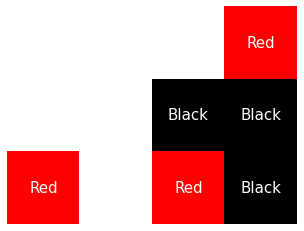

In [866]:
board, code, tree = do_action(3, 'R',board, verbose=False, tree=tree)
board, tree = min_one_play(board, tree)

show_board(board)